In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): l


In [2]:
m = 50

In [3]:
# Параметры пучка электронов и мишени
target = R(Material(m), 1e-2)
beams_energy = 0.075
brem = target.brem(beams_energy)
brem_e = brem * en

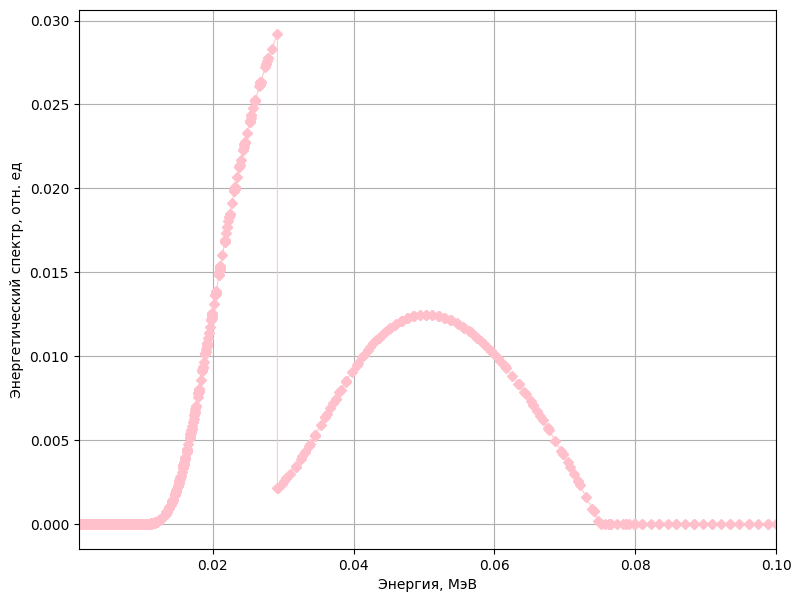

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [5]:
def rectangle_ideal(grid, material_num_1, material_num_2):
    signal = R(Material(1), 1).f()
    signal[:] = 0
    signal[Material(material_num_1).k_index() + 1:Material(material_num_2).k_index() + 1] = 1
    return signal

K = [Material(i).k_index() for i in range(11, 101)]
K.append(0)
resp_rectangle = [rectangle_ideal(en, i, i+1) for i in range(11, 100)]

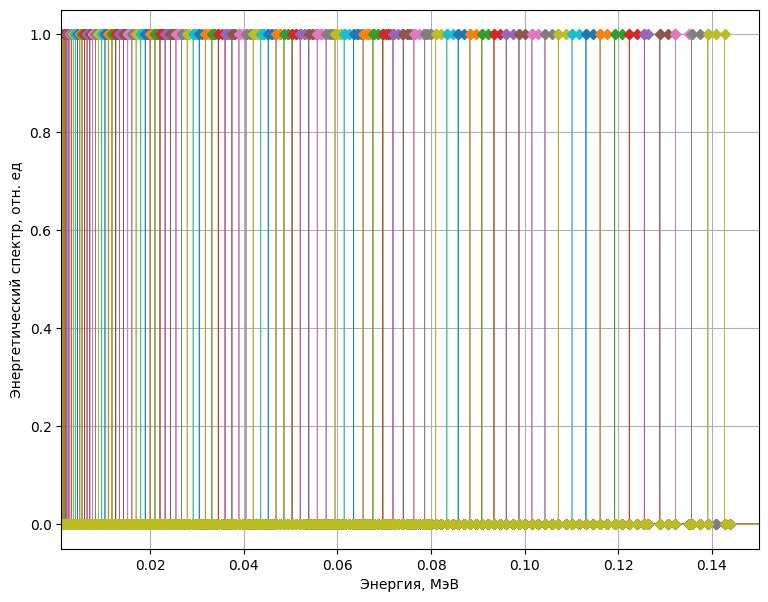

In [6]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_rectangle:
    ax.plot(en,i, ls='-', marker='D', lw='0.7', ms=5)
# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1.5e-1)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [7]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [8]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Прямое измерение спектра прямоугольниками

In [9]:
from garipov_deconvolution import get_coeff_simpson

In [10]:
signals_simpson = [sum(get_coeff_simpson(brem_e*r, en, EDGE)[0]) for r in resp_rectangle]

In [11]:
left_bounds = [Material(i).k_en() for i in range(11, 101)]
right_bounds = [Material(i).k_en() for i in range(12, 101)]
mean_en = [(i+j)/2 for i,j in zip(left_bounds,right_bounds)]
delta_en = [j-i for i,j in zip(left_bounds,right_bounds)]

In [12]:
signals_simpson = np.array(signals_simpson) / delta_en

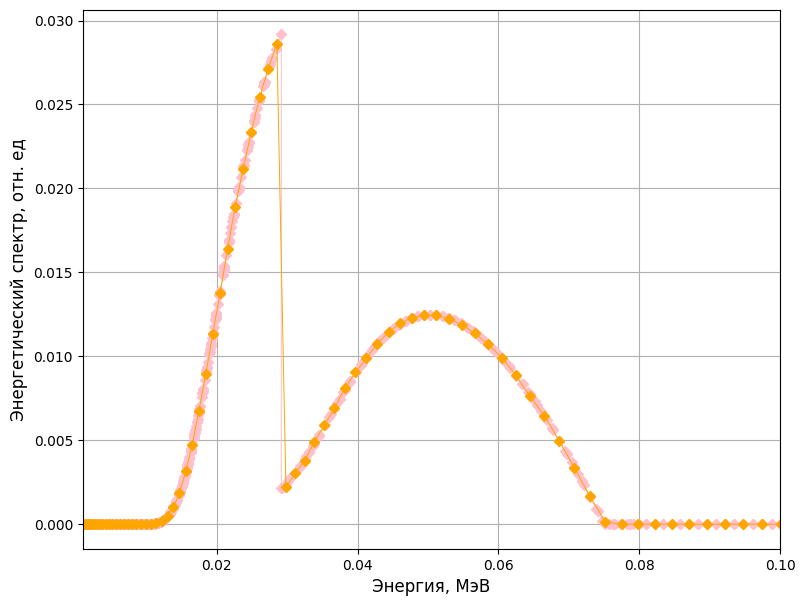

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))

# ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')
ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')
ax.plot(mean_en, signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
# ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Интегрирование по правилу Симпсона с постоянным шагом

In [24]:
def get_elementary_areas(mesh, numerical_function):
    
    if isinstance(mesh, np.ndarray):
        mesh = mesh.tolist()
        
    if isinstance(numerical_function, np.ndarray):
        numerical_function = numerical_function.tolist()
    
    edge_indices = []
    for i in range(1, len(en)):
        if en[i - 1] == en[i]:
            edge_indices.append(i - 1)
    
    mesh_areas = []
    val_areas = []
    
    reverse_mesh = mesh[::-1]
    reverse_function = numerical_function[::-1]
    
    while len(reverse_mesh) >= 3:
        point0 = reverse_mesh.pop()
        func0 = reverse_function.pop()
        point1 = reverse_mesh.pop()
        func1 = reverse_function.pop()
        point2 = reverse_mesh.pop()
        func2 = reverse_function.pop()
        
        one_mesh_area = [point0, point1, point2]
        one_val_area = [func0, func1, func2]
        
        mesh_areas.append(one_mesh_area)
        val_areas.append(one_val_area)
        
        if mesh.index(point2) not in edge_indices:
            reverse_mesh.append(point2)
            reverse_function.append(func2)

    return np.array(mesh_areas), np.array(val_areas)

In [25]:
areas = get_elementary_areas(en, brem_e)

In [21]:
mesh_areas = areas[0]
val_areas = areas[1]

In [26]:
def polinom_coeff(simple_mesh_area):
    x = simple_mesh_area
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (6*x20*x10 + 2*x20**2 - 3*x20*(x10+x20)) / (6*x10)
    c1 = x20**3 / (6*x10*x21)
    c2 = (x20*(2*x20 - 3*x10)) / (6*x21)
    return [c0, c1, c2]

In [27]:
def polinom_coeff_h(simple_mesh_area):
    x = simple_mesh_area
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (1/6)*x20
    c1 = (4/6)*x20
    c2 = (1/6)*x20
    return [c0, c1, c2]

In [28]:
polinom_coeff(mesh_areas[0])

[1.0833333333333337e-06, 4.3333333333333305e-06, 1.0833333333333324e-06]

In [29]:
coeff_triplets = [polinom_coeff(val) for val in mesh_areas]

In [30]:
coeff_triplets*val_areas

array([[1.00660919e-265, 2.98955568e-263, 5.30493918e-262],
       [6.52915591e-263, 4.39957447e-262, 1.85162351e-262],
       [3.26348644e-261, 1.13555340e-256, 2.01744124e-253],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [31]:
def get_k_index_in_areas(m):
    mesh_areas = get_elementary_areas(en, en)[0]
    k_area_index = 0
    
    k_en = en[Material(m).k_index()]
    for i,area in enumerate(areas):
        if area[-1] == k_en:
            k_area_index = i
            
    return k_area_index

In [32]:
a1 = [1,2,3]
a2 = [4,5,6]
a3 = [6,7,8]

areas = [a1, a2, a3]

def combine_lists(a, b):
    return a[:len(a) -1] + [a[-1] + b[0]] + b[1:]

def combine_areas(areas, edge_area_indices):
    result = areas[0]

    for i, part in enumerate(areas):
        if i < len(areas) - 1:
            if i not in edge_area_indices:
                result = combine_lists(result, areas[i + 1])
            else:
                result += areas[i + 1]
                
    return result

In [33]:
combine_areas(areas, [0])

[1, 2, 3, 4, 5, 12, 7, 8]

In [34]:
signals_simpson = [sum(get_coeff_simpson(brem_e*r, en, EDGE)[0]) for r in resp_rectangle]

In [35]:
def get_simpson_ununiform_coeff(mesh, func):
    simple_areas = get_elementary_areas(mesh, func)
    mesh_areas = simple_areas[0]
    val_areas = simple_areas[1]
    coeff_triplets = [polinom_coeff(val) for val in mesh_areas]
    K = np.array(coeff_triplets)*np.array(val_areas)
    K = K.tolist()
#     coefficients = combine_areas(K, [get_k_index_in_areas(m)])
    coefficients = combine_areas(K, [])
    return coefficients

In [38]:
%timeit signals_simpson_ununiform = [sum(get_simpson_ununiform_coeff(en, brem_e*r)) for r in resp_rectangle]

1.73 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


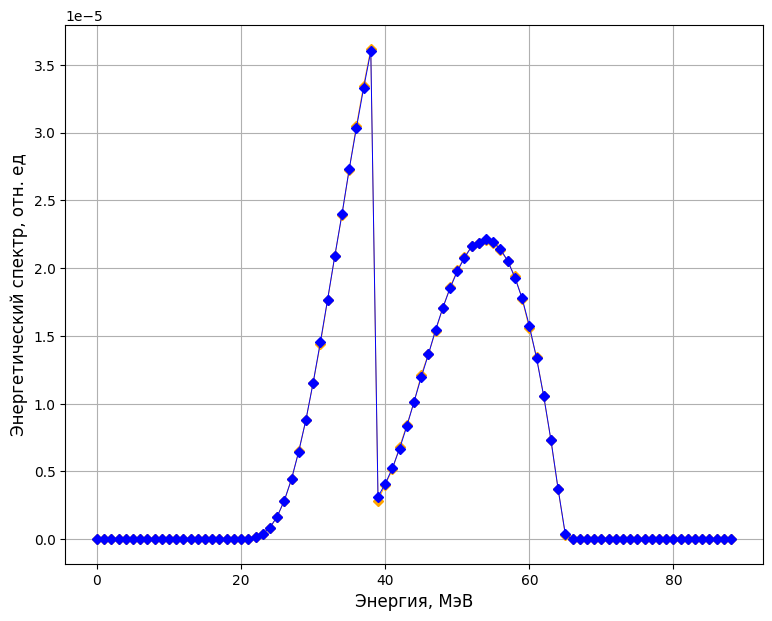

In [37]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')
ax.plot(list(range(len(signals_simpson))), signals_simpson_ununiform, ls='-', marker='D', lw='0.7', ms=5, color='blue')
# ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')
# ax.plot(mean_en, signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
# ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)